In [1]:
import torch
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# MOUNT google drive onto COLAB notebook
from google.colab import drive
drive.mount('/content/drive')

# install and import BertTokenizer
!pip install transformers
from transformers import BertTokenizer

# import tensor datasets for creating batches of the data
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define seed for training
SEED = 2021

# Set seed for all randoms
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# load dataset and select 80k samples with SEED
df = pd.read_csv("drive/MyDrive/training16M.csv", encoding = "ISO-8859-1", header=None)
df.columns=["LABEL", "timestamp", "year", "query", "userid", "TEXT"]
df = df.sample(n=80000, random_state=SEED)

In [3]:
import re
def tokenize_truncate(sentence, tokenizer, max_input_length):  
    sentence= re.sub(r"(@[A-Za-z0–9_]+)|[^\w\s]|#|http\S+", "", sentence)
    tokens = tokenizer.tokenize(sentence) 
    tokens = [tokenizer.cls_token] + tokens[:max_input_length-2] + [tokenizer.sep_token]
    return tokens

# Create BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
max_input_length=64

input_ids = [tokenizer.convert_tokens_to_ids(tokenize_truncate(sent, tokenizer, max_input_length)) for sent in df.TEXT.values]

In [4]:
def get_data_tensors(input_ids, labels, train_test_ratio=0.375, train_valid_ratio=0.3, max_input_length=64):
    # Split data into training, testing and validation sets
    train_text, test_inputs, train_label, test_labels = train_test_split(input_ids, labels, 
                                                                random_state=SEED, test_size=train_test_ratio)
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_text, train_label, 
                                                                random_state=SEED, test_size=train_valid_ratio)

    # Pad data into arrays of length max_input_length
    train_inputs = pad_sequences(train_inputs, maxlen=max_input_length, dtype="long", truncating="post", padding="post")
    validation_inputs = pad_sequences(validation_inputs, maxlen=max_input_length, dtype="long", truncating="post", padding="post")
    test_inputs = pad_sequences(test_inputs, maxlen=max_input_length, dtype="long", truncating="post", padding="post")

    # Convert inputs and labels into Long and Float tensors
    train_inputs = torch.LongTensor(train_inputs)
    validation_inputs = torch.LongTensor(validation_inputs)
    train_labels = torch.FloatTensor(train_labels.to_list())
    validation_labels = torch.FloatTensor(validation_labels.to_list())

    test_inputs = torch.LongTensor(test_inputs)
    test_labels = torch.FloatTensor(test_labels.to_list())
    return train_inputs, train_labels,validation_inputs, validation_labels, test_inputs, test_labels

In [5]:
# Convert Tensors to batches
def get_loaders(train_inputs, train_labels, validation_data, validation_labels):
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_loader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
    return train_loader, validation_loader

In [6]:
class Feedforward(torch.nn.Module):
  def __init__(self, layers, embedding_dim):
    super(Feedforward, self).__init__()

    # get vocabulary list length from BERT tokenizer
    vocab_size=len(tokenizer.vocab.keys())

    # initialize embedding layer
    self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

    # create list for NN layers and activation layers
    self.fc = torch.nn.ModuleList()
    self.activations = []

    # append first layer
    self.fc.append(torch.nn.Linear(embedding_dim*layers[0], layers[0]))
    # self.fc.append(torch.nn.RNN(embedding_dim, layers[0]))
    for i in range(len(layers)-1):
      # Append activation function for previous layer
      self.activations.append(torch.nn.ReLU())
      # append layer with given dimensions
      self.fc.append(torch.nn.Linear(layers[i], layers[i+1]))
      print(layers[i], layers[i+1])

    # # declare dropout layer function
    self.dropout = torch.nn.Dropout(0.2)
            
  def forward(self, x):
    # Apply embeddding layer at beginnning and then train model
    y = self.embeddings(x).squeeze()

    for layer in range(len(self.fc)):
      if layer!=len(self.fc)-1:
        # Apply activation function for all layers other than the last
        y= self.dropout(self.activations[layer](self.fc[layer](y)))
      else:
        # No activation function since we are using BCEWithLogitsLoss
        y= self.fc[layer](y)

    return y

In [7]:
def evaluate_model(inputs, labels, data_name=""):
  """
  Model to evaluate model given inputs(text) and labels
  :param inputs: TEXT to be classified
  :param labels: Actual values of the LABELS to be predicted
  :param data_name: Name of data being evaluated 
  """
  # Initiate model in evaluation mode
  model.eval()
  # Squeeze output to 1D
  pred_labels = model(inputs)
  # pred_labels = model(inputs).squeeze(1)
  # pred_labels=torch.tensor(pred_labels)
  pred_labels = (pred_labels>THRESHOLD).float()
  # use criterion to calculate loss
  before_train = criterion(pred_labels.squeeze(), labels)
  print(f'{data_name}\n\tLoss: {before_train.item()}')
  print(f"\tAccuracy: {accuracy_score(pred_labels, labels)}")
  return before_train.item(), accuracy_score(pred_labels, labels)

In [8]:
# Convert dataset 0s and 4s to 0s and 1s
label_dict={0: 0, 4: 1}
# Batch size for DataLoader. For fine-tuning BERT on a specific task, recommended size is 16 or 32
batch_size = 16
# NN hyper-parameters
nn_topology = (max_input_length, 128, 64, 32, 1)
THRESHOLD=0
# 0.5, 45

df.LABEL= df.LABEL.replace(label_dict)
train_inputs, train_labels,validation_inputs, validation_labels, test_inputs, test_labels = get_data_tensors(input_ids, df.LABEL, train_test_ratio=0.375, train_valid_ratio=0.3, max_input_length=max_input_length)
print(f"Number of training: {len(train_inputs)}")
print(f"Number of validation: {len(validation_inputs)}")
print(f"Number of testing: {len(test_inputs)}")

train_loader, validation_loader = get_loaders(train_inputs, train_labels, validation_inputs, validation_labels)
model = Feedforward(nn_topology,1)

Number of training: 35000
Number of validation: 15000
Number of testing: 30000
64 128
128 64
64 32
32 1


In [20]:
# 45 epochs with 0.5, 15 with 0.01
EPOCHS = 5
LEARNING_RATE=0.5
# EPOCHS = 15
# 20
# LEARNING_RATE=0.1

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =LEARNING_RATE)

# Pre-training evaluation
evaluate_model(validation_inputs, validation_labels, data_name="Validation")
# train_accuracy=[]
# validation_accuracy=[]
model.train()
for epoch in range(EPOCHS):
    train_loss=0
    valid_loss=0
    # model.train()
    for data, target in train_loader:
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the loss
          loss = criterion(output.squeeze(), target)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update running training loss
          train_loss += loss.item()*data.size(0)
          
    loss, acc = evaluate_model(validation_inputs, validation_labels, data_name=f"{epoch}: Validation")
    validation_accuracy.append(acc)

    loss, acc = evaluate_model(train_inputs, train_labels, data_name=f"{epoch}: Train")
    train_accuracy.append(acc)

Validation
	Loss: 0.6404106020927429
	Accuracy: 0.7328666666666667
0: Validation
	Loss: 0.6406102180480957
	Accuracy: 0.7316666666666667
0: Train
	Loss: 0.6165414452552795
	Accuracy: 0.7787714285714286
1: Validation
	Loss: 0.6547743082046509
	Accuracy: 0.7231333333333333
1: Train
	Loss: 0.6297004818916321
	Accuracy: 0.7720285714285714
2: Validation
	Loss: 0.6236409544944763
	Accuracy: 0.7268
2: Train
	Loss: 0.5984602570533752
	Accuracy: 0.7776571428571428
3: Validation
	Loss: 0.6284019351005554
	Accuracy: 0.7306666666666667
3: Train
	Loss: 0.594577431678772
	Accuracy: 0.7998571428571428
4: Validation
	Loss: 0.6412164568901062
	Accuracy: 0.7326
4: Train
	Loss: 0.6044119000434875
	Accuracy: 0.8057142857142857


In [21]:
# Post-training evaluation
evaluate_model(train_inputs, train_labels, data_name="Training")
evaluate_model(validation_inputs, validation_labels, data_name="Validation")
evaluate_model(test_inputs, test_labels, data_name="Testing")

Training
	Loss: 0.6044119000434875
	Accuracy: 0.8057142857142857
Validation
	Loss: 0.6412164568901062
	Accuracy: 0.7326
Testing
	Loss: 0.6385477185249329
	Accuracy: 0.7372


(0.6385477185249329, 0.7372)

In [22]:
def predict_sentence(sentence):
    test_sents=[sentence]
    test_sents = [tokenizer.convert_tokens_to_ids(tokenize_truncate(sent, tokenizer, max_input_length)) for sent in test_sents]
    sent_inputs = pad_sequences(test_sents, maxlen=max_input_length, dtype="long", truncating="post", padding="post")
    sent_inputs = torch.LongTensor(sent_inputs)
    # test_labels = torch.FloatTensor(test_labels.to_list())
    # Initiate model in evaluation mode
    model.eval()
    # Squeeze output to 1D
    pred_labels = model(sent_inputs)
    return "pos" if (pred_labels>THRESHOLD).float() else  "neg"

print(predict_sentence("It was a good experience"))
print(predict_sentence("It was a bad experience"))
print(predict_sentence("That was terrible")) 

pos
neg
pos


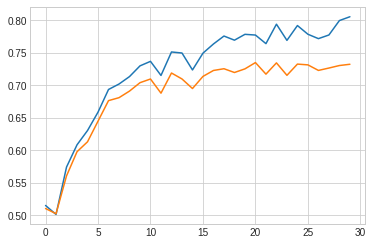

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.plot(range(len(train_accuracy)), train_accuracy)
ax.plot(range(len(validation_accuracy)), validation_accuracy)
# train_accuracy